# 📅 Day 33 – Inference with the Fine-Tuned Model

### 🔁 Building on Day 32

Day 32 fine-tuned a pretrained LLaMA 3.1 model on a curated subset of Amazon review data (Appliances category), using prompt→price pairs. The model was trained on 25k examples and pushed to the Hugging Face Hub.

**🎯 Objectives for Day 33**

- Load the fine-tuned model from Hugging Face
- Load the corresponding test dataset (with prices hidden from the model)
- Run **inference** using the model on real test examples
- Evaluate how well the model can **predict prices** based on product descriptions

**🧠 A Refresher on the Inference Workflow**
- Load a quantized base model and fine-tuned adapter (LoRA)
- Use only the product **description text** (price is held out)
- Tokenize and run through the model to generate predictions
- Extract numeric prices from generated tokens

**🛠️ Fine-Tuned Model Loading**
- The model is structured as a **base model + adapter**
- Adapter is loaded via `PeftModel.from_pretrained`, combining both components
- You can specify a `revision` to pick a checkpoint (e.g., before overfitting)

**🔍 Prediction Strategy**
Two price extraction methods:
1. **Basic** — use the most likely predicted token (argmax).
2. **Improved** — take top 3 token probabilities, compute a **weighted average**, allowing for finer-grained price estimates.

> This accounts for the fact that the model is solving a regression-like problem using classification tools (tokens).


**🔍 What is Inference?**

Inference is the process of **using a trained model to make predictions** on new, unseen data.

In our context, after fine-tuning a LLaMA model on prompt→price examples, inference means:
- Feeding in a **new product description** (the prompt)
- Asking the model to **predict the price** based on what it learned during training

Unlike training, which updates the model's internal parameters, inference simply:
1. Tokenizes the input prompt
2. Runs it through the model (a **forward pass**)
3. Produces output tokens — in this case, a predicted **price**

**🧠 Key Properties of Inference:**
- **No learning** happens — weights are frozen
- It’s **fast and lightweight** (compared to training)
- Can be run on smaller GPUs or CPUs
- Often used for **evaluation**, **deployment**, or **real-world predictions**

**🏁 Inference Results – A Major Milestone**

After running our fine-tuned model on the test dataset, we reached a **breakthrough moment** in the project:

**Outcome**

- 📈 Final Test Error: `$18.93`
- 🔁 RMSLE: `0.44`
- 🎯 Hit Accuracy: `90.4%`

This reflects how accurately the model predicted product prices on unseen test data. An average error under $20, combined with over 90% hit accuracy, is **outstanding**, especially given real-world pricing fluctuations.

**🧠 Why This Is Impressive**

- The model is an **8B parameter open-source LLaMA** variant, fine-tuned specifically for **price prediction**.
- It was quantized and fine-tuned using **PEFT** techniques for maximum efficiency.
- Despite its smaller size and low-cost training, it **outperformed GPT-4** on this narrow task.

**📊 Output Insights**

- The scatter plot comparing predicted and actual prices shows a **tight clustering near the diagonal**, indicating strong correlation.
- Color-coded accuracy:
  - 🟢 Green: Correct or near-correct predictions
  - 🟡 Yellow: Acceptable but slightly off
  - 🔴 Red: Outliers with high error
- Most predictions are within a tight band around the true values — excellent consistency.

**🏆 Why It Worked**

- **Task-Specific Fine-Tuning**: Focused only on price prediction using product descriptions.
- **PEFT + Quantization**: Enabled parameter-efficient learning without heavy compute cost.
- **High-Quality Curation**: The fine-tuning dataset was targeted, clean, and relevant (25k appliance samples).

**🎉 Final Thoughts**

This is a **clear win**:
- ✅ Outperformed GPT-4 and Claude on this task
- ✅ Achieved with efficient, fine-tuned open-source tools
- ✅ Shows that **focused adaptation beats brute-scale** when done right

This result is what the entire project was building toward — proof that smart training strategies with the right data can compete with the biggest models available today.

---




In [1]:
# pip installs

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt

In [21]:
# Constants
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "lite-data"
HF_USER = "david125tran"

# The run itself
RUN_NAME = "2025-07-05_16.26.10"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
# REVISION = "e8d637df551603dc86cd7a1598a8f44af4d7ae36"
REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Data
DATASET_NAME = f"{HF_USER}/lite-data"

# Hyperparameters for QLoRA
QUANT_4_BIT = True

%matplotlib inline

# Used for writing to output in color
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

### Log in to HuggingFace

If you don't already have a HuggingFace account, visit https://huggingface.co to sign up and create a token.

Then select the Secrets for this Notebook by clicking on the key icon in the left, and add a new secret called `HF_TOKEN` with the value as your token.


In [22]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [23]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [24]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color\n\nPrice is $",
 'price': 65.99}

**test[0]:**

{'text': "How much does this cost to the nearest dollar?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color\n\nPrice is $",
 **'price': 65.99**}
  
 ***The fine-tuned model will look to predict the price***

## Now load the Tokenizer and Model

In [26]:
# Check if we want to load the model in 4-bit precision
if QUANT_4_BIT:
    # Configure quantization for 4-bit loading using bitsandbytes
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,                      # Enable 4-bit quantization
        bnb_4bit_use_double_quant=True,         # Use nested quantization for better accuracy
        bnb_4bit_compute_dtype=torch.bfloat16,  # Compute in bfloat16 (efficient on A100s)
        bnb_4bit_quant_type="nf4"               # Use NormalFloat4 (NF4) quantization format (default for QLoRA)
    )
else:
    # Configure quantization for 8-bit loading (slightly less efficient than 4-bit but more stable)
    quant_config = BitsAndBytesConfig(
        load_in_8bit=True,                      # Enable 8-bit quantization
        bnb_8bit_compute_dtype=torch.bfloat16   # Compute in bfloat16 (still efficient)
    )


In [27]:
PeftModel.from_pretrained(base_model, "david125tran/lite-data-2025-07-05_16.26.10")

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [28]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5700.6 MB


In [ ]:
fine_tuned_model

# THE MOMENT OF TRUTH!

## Use the model in inference mode

 - GPT-4o had an average error of \$76.  
 - Llama 3.1 base model had an average error of \$396.   
 - A human had an error of \$127.  

## Caveat

Keep in mind that prices of goods vary considerably; the model can't predict things like sale prices that it doesn't have any information about.

In [29]:
def extract_price(s):
    # Check if the expected price phrase is in the string
    if "Price is $" in s:
        # Split the string at "Price is $" and take the part after it
        contents = s.split("Price is $")[1]

        # Remove commas from numbers (e.g., 1,299 → 1299)
        contents = contents.replace(',', '')

        # Use regex to search for the first valid number (integer or decimal)
        match = re.search(r"[-+]?\d*\.\d+|\d+", contents)

        # Return the matched number as a float, or 0 if no match found
        return float(match.group()) if match else 0

    # If "Price is $" is not found, return 0
    return 0


In [30]:
extract_price("Price is $a fabulous 899.99 or so")

899.99

In [31]:
# Original prediction function takes the most likely next token

def model_predict(prompt):
    # Set the random seed for reproducibility (so you get the same output each time)
    set_seed(42)

    # Tokenize the input prompt and move the tensor to the GPU
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")

    # Create an attention mask with ones (no padding, all tokens attended to)
    attention_mask = torch.ones(inputs.shape, device="cuda")

    # Generate model output (prediction) with up to 3 new tokens
    outputs = fine_tuned_model.generate(
        inputs,
        attention_mask=attention_mask,
        max_new_tokens=3,       # Only allow generation of up to 3 tokens
        num_return_sequences=1  # Only one output sequence
    )

    # Decode the generated token IDs into a string
    response = tokenizer.decode(outputs[0])

    # Extract the numeric price value from the response text
    return extract_price(response)



In [32]:
# An improved prediction function takes a weighted average of the top 3 choices
# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [33]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $39.12 Truth: $65.99 Error: $26.86 SLE: 0.26 Item: Setpower Insulated P...
2: Guess: $8.34 Truth: $9.68 Error: $1.34 SLE: 0.02 Item: TUAIC Refrigerator D...
3: Guess: $83.94 Truth: $155.98 Error: $72.04 SLE: 0.38 Item: Kegco Secondary Regu...
4: Guess: $9.05 Truth: $5.59 Error: $3.46 SLE: 0.18 Item: Refrigerator Door Sp...
5: Guess: $48.78 Truth: $98.40 Error: $49.62 SLE: 0.48 Item: Ice-O-Matic Float Va...
6: Guess: $25.09 Truth: $54.99 Error: $29.90 SLE: 0.58 Item: Wireless Temperature...
7: Guess: $6.98 Truth: $5.71 Error: $1.27 SLE: 0.03 Item: 3Inch Thermometer Hy...
8: Guess: $10.99 Truth: $9.53 Error: $1.46 SLE: 0.02 Item: GE GE Timer Knob Ass...
9: Guess: $11.52 Truth: $11.24 Error: $0.28 SLE: 0.00 Item: newlifeapp Dryer Lin...
10: Guess: $24.45 Truth: $12.88 Error: $11.57 SLE: 0.37 Item: Away NV350 NV351 NV3...
11: Guess: $100.12 Truth: $99.99 Error: $0.14 SLE: 0.00 Item: Refrigerator Ice Mak...
12: Guess: $17.97 Truth: $16.99 Error: $0.98 SLE: 0.00 Item: 2 PACKS Water

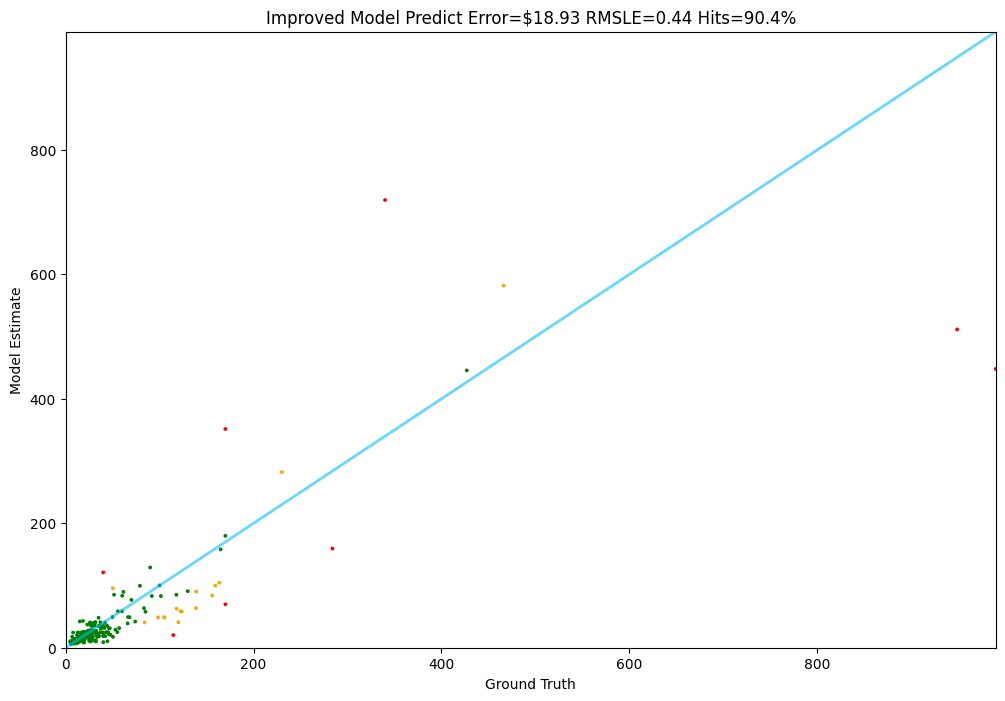

In [34]:
Tester.test(improved_model_predict, test)